In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit


import sys
sys.path.append('../')
from custom_tools import plot_2D_pulse, plot_one_pulse, get_mids_from_edges

this_directory = '/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/model_data/J1808/2019/'

counts = np.reshape(np.loadtxt(this_directory+'2019_photon_count.csv', skiprows=1), (255, 64))
phase_edges = np.loadtxt(this_directory+'2019_phase_edge.csv', skiprows=1)
energy_edges = np.loadtxt(this_directory+'2019_energy_edge.csv', skiprows=1)


/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1


In [2]:
phase_mids = get_mids_from_edges(phase_edges)
energy_mids = get_mids_from_edges(energy_edges)



In [3]:
half = int(len(phase_mids)/2)
print('total counts:',np.sum(counts[:,:half])) #cutting off half of data to measure total counts since phase goes up to 2.

total counts: 24998635.0


(<Figure size 500x300 with 2 Axes>,
 <AxesSubplot: xlabel='Phase', ylabel='Energy (keV)'>)

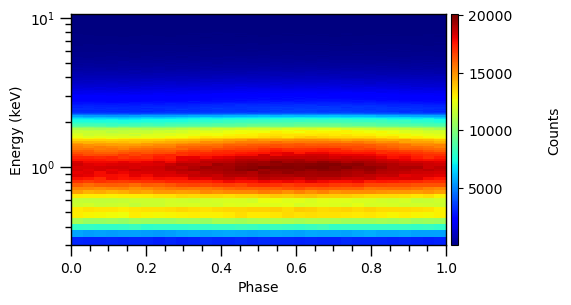

In [4]:
plot_one_pulse(counts, phase_mids, energy_mids, cm=cm.jet)

# Fitting

In [5]:
def sinfunc(phase, A, p, c):
    
    return A * np.sin(phase*2.0*np.pi + p) + c


def sin2func(phase, A, p, c, A2, p2):

        return A*np.sin(phase*2.0*np.pi + p) + A2*np.sin(phase*4.0*np.pi + p2) + c

In [6]:
def fit2sin(phase, counts):
    
    
    #counts=data.sum(axis=0)

    c0 = 6500
    A0 = 1000
    p0 = 0.15*2.0*np.pi
    A20 = 100
    p20 = 0.01*2.0*np.pi

    guess = [A0, p0,c0, A20, p20]
    popt, pcov = scipy.optimize.curve_fit(sin2func, phase, counts, p0=guess)
    #A, p, c, A2, p2 = popt
    #print(popt)
    
    return popt 

 
def fitsin(phase, counts):
    
    
    #counts=data.sum(axis=0)

    c0 = 6500
    A0 = 1000
    p0 = 0.15*2.0*np.pi
    A20 = 100
    p20 = 0.01*2.0*np.pi

    guess = [A0, p0,c0]
    popt, pcov = scipy.optimize.curve_fit(sinfunc, phase, counts, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

In [7]:
n_energies = len(energy_mids)

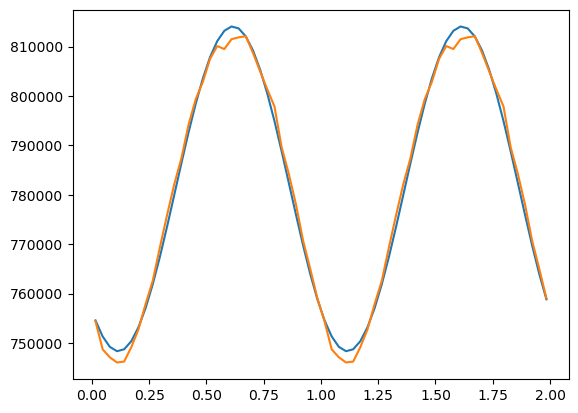

In [8]:
summed_counts = counts.sum(axis=0)

(A1, p1, c1), perr = fitsin(phase_mids, summed_counts)
y=sinfunc(phase_mids, A1, p1, c1)

fig, ax = plt.subplots()

ax.plot(phase_mids, y)
ax.plot(phase_mids,summed_counts)

summed_phase = p1-np.pi

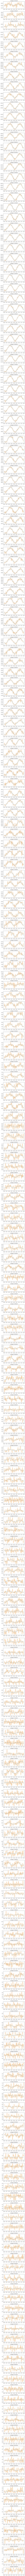

In [9]:
n_plots = n_energies #  n_plots = 2 #  
fig, axes = plt.subplots(n_plots, figsize=(5,2*n_plots))

fit_amplitudes = []
fit_phases = []
fit_constants = []
fit_errors = np.empty((n_plots, 3))

for i in range(n_plots):
    counts_slice = counts[i] 
    (A1, p1, c1), perr = fitsin(phase_mids, counts_slice)
    fit_amplitudes.append(A1)
    fit_phases.append(p1)
    fit_constants.append(c1)
    fit_errors[i] = perr
    y=sinfunc(phase_mids, A1, p1, c1)

    axes[i].plot(phase_mids, y)
    axes[i].plot(phase_mids,counts_slice)
    axes[i].set_title(f' energy: {energy_mids[i]:.2f} keV')
    
plt.tight_layout()

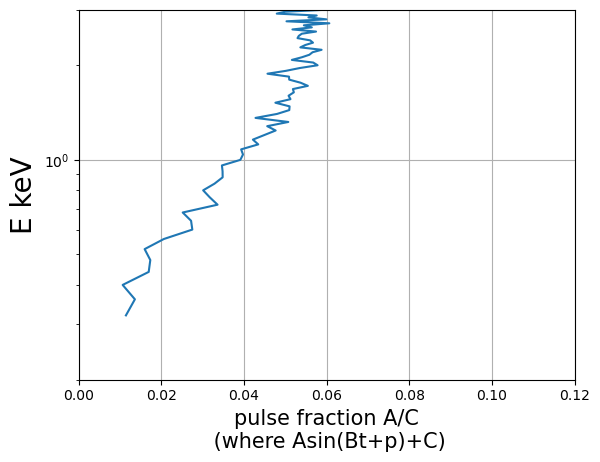

In [10]:
fig, ax = plt.subplots()
ax.semilogy(abs(np.asarray(fit_amplitudes)/fit_constants), energy_mids)
ax.set_ylabel('E keV',fontsize=20)
ax.set_xlabel('pulse fraction A/C\n (where Asin(Bt+p)+C)',fontsize=15)
ax.set_ylim([0.2,3])
ax.set_xlim([0,0.12])
ax.grid()

In [11]:
# fig, ax = plt.subplots()
# ax.plot(energy_mids, abs(np.asarray(fit_phases-summed_phase)))
# ax.set_ylim([0,1])
# ax.set_xlabel('E keV')
# ax.set_ylabel('fitted phase')
# plt.show()

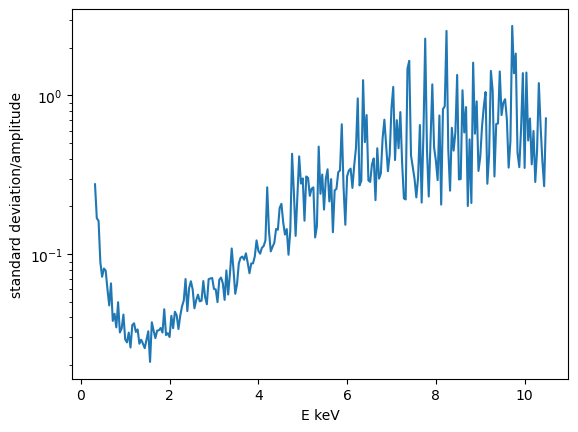

In [12]:
a1_sd = fit_errors[:,0]
sd_per_a1 = abs(a1_sd/fit_amplitudes)


fig, ax = plt.subplots()
ax.semilogy(energy_mids, sd_per_a1)
ax.set_xlabel('E keV')
ax.set_ylabel('standard deviation/amplitude')
plt.show()

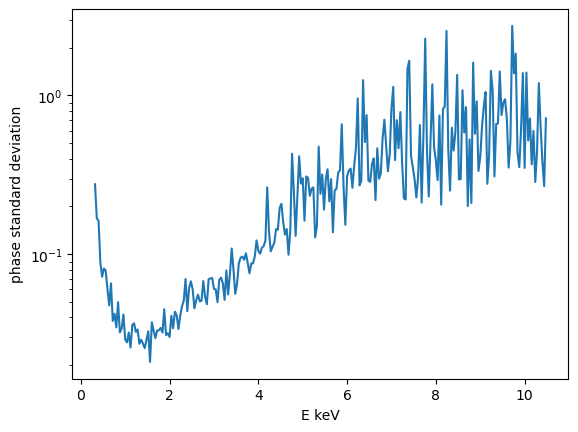

In [13]:
p1_sd = fit_errors[:,1]

fig, ax = plt.subplots()
ax.semilogy(energy_mids, p1_sd)
ax.set_xlabel('E keV')
ax.set_ylabel('phase standard deviation')
plt.show()

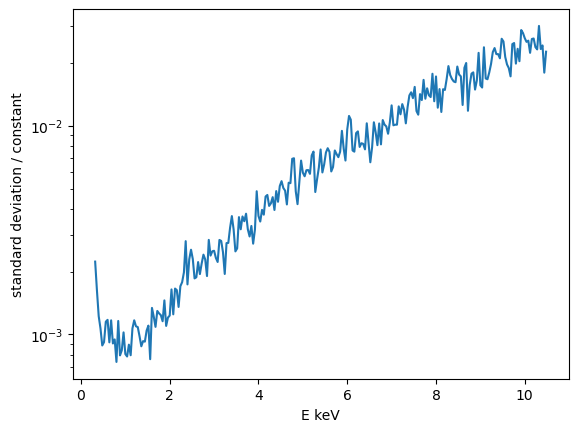

In [14]:
c1_sd = fit_errors[:,2]
sd_per_c1 = abs(c1_sd/fit_constants)

fig, ax = plt.subplots()
ax.semilogy(energy_mids, sd_per_c1)
ax.set_xlabel('E keV')
ax.set_ylabel('standard deviation / constant')
plt.show()

## removed sines from signal

In [15]:
sines = np.empty(counts.shape)
for i, fit_amplitude, fit_phase, fit_constant in zip(range(n_energies), fit_amplitudes, fit_phases, fit_constants):
        sines[i]=sinfunc(phase_mids, fit_amplitude, fit_phase, abs(fit_amplitude))

In [16]:
background = counts-sines

(<Figure size 500x300 with 2 Axes>,
 <AxesSubplot: xlabel='Phase', ylabel='Energy (keV)'>)

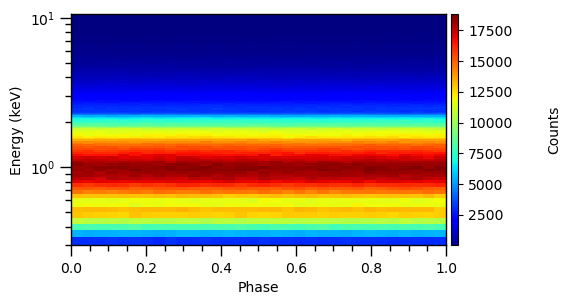

In [17]:
plot_one_pulse(background, phase_mids, energy_mids, cm=cm.jet)

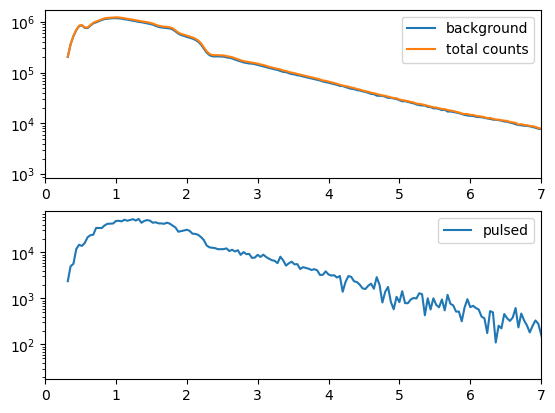

In [23]:
fig, axes = plt.subplots(2,1)

average_counts = counts.sum(axis=1)
average_background = background.sum(axis=1)
average_pulsed = average_counts-average_background

axes[0].semilogy(energy_mids, average_background, label='background')
axes[0].semilogy(energy_mids, average_counts, label='total counts')
axes[1].semilogy(energy_mids, average_pulsed, label='pulsed')
for ax in axes:
    ax.set_xlim([0, 7])
    ax.legend()

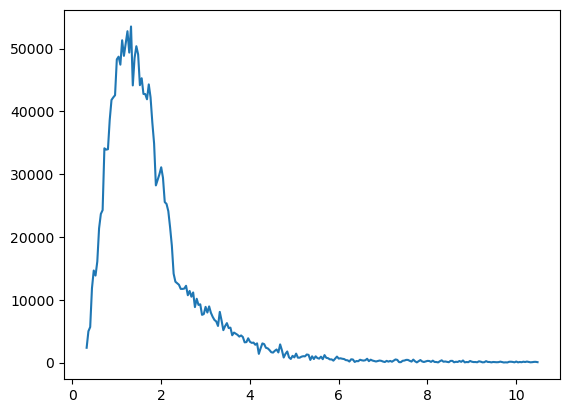

In [19]:
plt.plot(energy_mids, average_pulsed)

In [20]:
# np.savetxt('J1808_2019_nonpulsed.txt',background)

In [21]:
# np.linspace(0.015625,1.015625,33)[:-1]
# np.linspace(0.32, 10.48, 255)

(<Figure size 500x300 with 2 Axes>,
 <AxesSubplot: xlabel='Phase', ylabel='Energy (keV)'>)

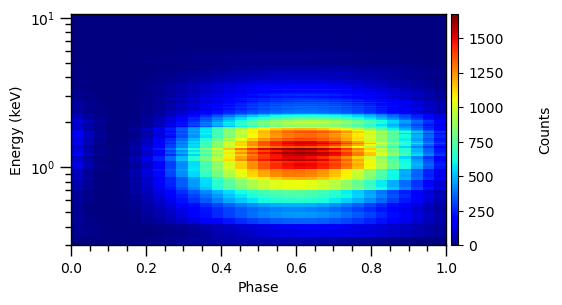

In [22]:
plot_one_pulse(sines, phase_mids, energy_mids, cm=cm.jet)